In [1]:
import sys, os
#path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir, 'dir1')))
#print(os.getcwd())
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))

import json
import yaml
from underpinnings.OccupancyMap2 import OccupancyMap2, LidarMeasurement, ExactLidarMeasurement
import numpy as np
from gyrii.underpinnings.BayesianArray import BayesianArray

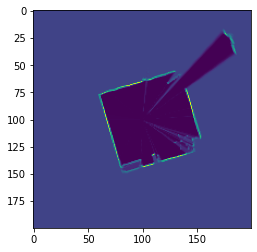

In [2]:
import matplotlib.pyplot as plt

#mymap=OccupancyMap2(0.05,200,200)
mymap=OccupancyMap2.load_from_file("../local_map.npy")
plt.figure()
plt.imshow(mymap.gridmap_logodds[100:300,100:300])
plt.show()

In [3]:
import json
import yaml

    
def dict_array_upend(mydict,key,elem):
    if key not in mydict:
        mydict[key]=[]
    mydict[key.append(elem)]

def load_sensor_log_file(fname):
    response=[]
    first_timestamp=0
    f=open(fname,'r')
    for line in f.readlines():        
        dat=json.loads(line)
        timestamp=dat["timestamp"]-first_timestamp
        response.append(dat)
        if first_timestamp==0:                        
            first_timestamp=timestamp
    return response,first_timestamp

sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210420-143409.txt")

print(sensor_log[-14])
last_pose_log=sensor_log[-1]

last_lidar_pose_log=sensor_log[-14]

last_compass_pose_log=sensor_log[-5]
compass_heading=last_compass_pose_log['pose_measurement']['vals'][2]
print("last compase heading {}".format(compass_heading))
last_state_log=sensor_log[-2]
test_lidar_scan=last_state_log["lidar/lidar_scan"]
latest_pose=BayesianArray.from_object(last_pose_log["latest_pose"])
print("latest pose {}".format(latest_pose.pretty_str()))


{'pose_measurement': {'vals': [-0.35099756607415694, 0.4591956917448999, -1.2470511677050706], 'covariance': [[0.0006424480603366905, -2.7474568512320108e-05, 2.7751471598502775e-07], [-2.7474568512320108e-05, 0.001021295413198071, 5.219761187857941e-05], [2.7751471598502775e-07, 5.219761187857941e-05, 0.0003463025780090471]]}, 'timestamp': 1618954602.8504562, 'notes': 'lidar'}
last compase heading -3.1120434913409953
latest pose  -0.351+/-0.009 0.461+/-0.010 -1.323+/-0.007


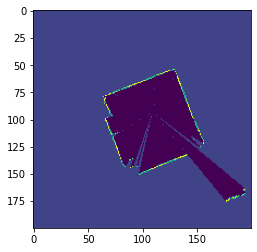

In [4]:
lidarmap=OccupancyMap2(mymap.resolution,mymap.npoints_x,mymap.npoints_x)
m_test=ExactLidarMeasurement([ x[2]/1000 for x in test_lidar_scan], [ np.radians(x[1]) for x in test_lidar_scan] )
lidarmap.apply_exact_lidar_measurement3(latest_pose.vals,m_test,weight=10)    
plt.figure()
plt.imshow(lidarmap.gridmap_logodds[100:300,100:300])
plt.show()

In [5]:
#posemap,xs,ys,ts,counts=mymap.get_lidar_pose_map2_withtheta(latest_pose.vals,m_test,theta_points=89,theta_res=np.radians(2))
posemap,xs,ys,ts,counts=mymap.get_lidar_pose_map2_withtheta(latest_pose.vals,m_test,theta_points=40,theta_res=np.radians(2))



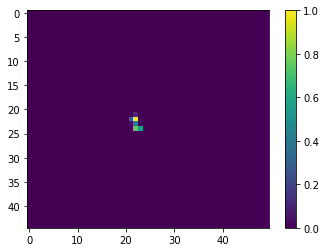

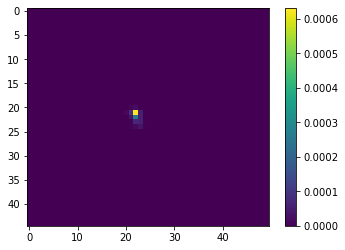

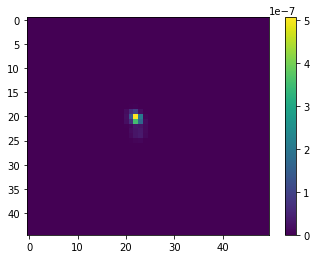

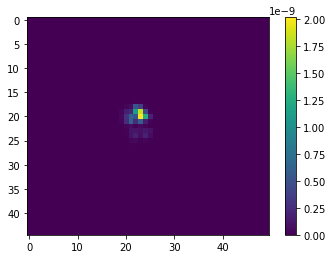

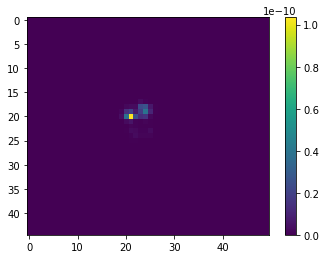

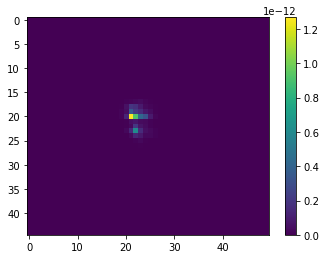

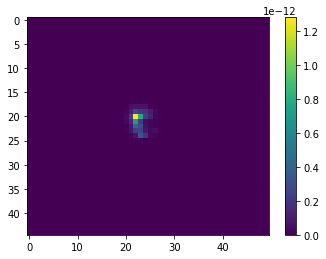

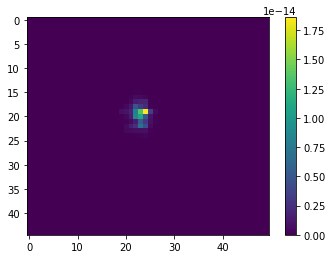

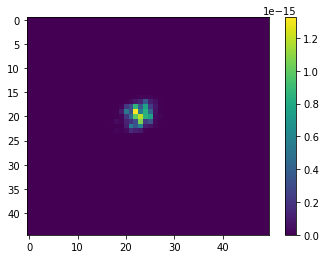

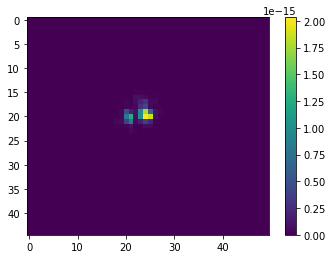

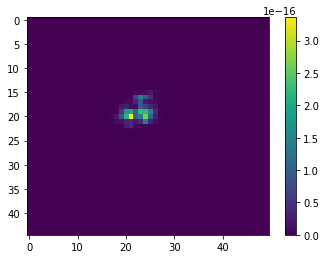

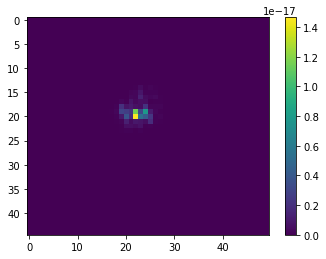

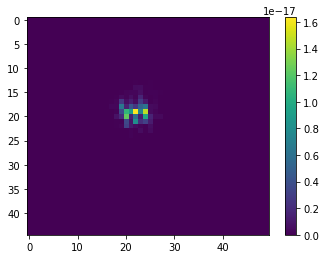

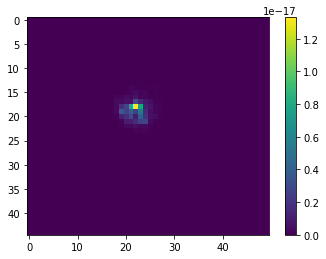

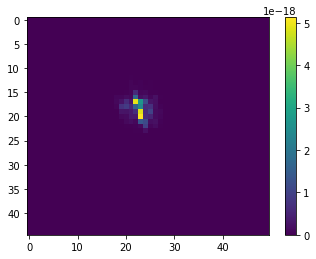

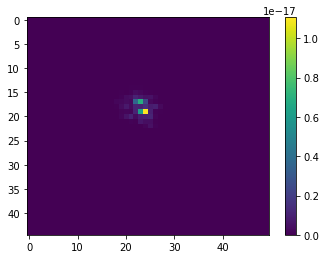

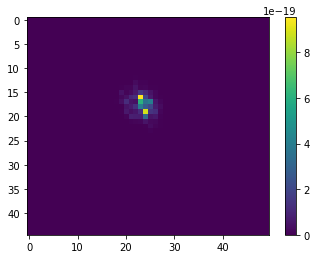

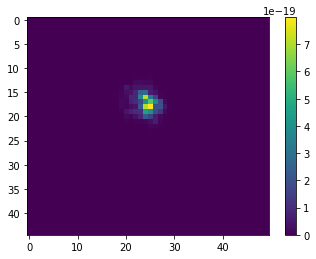

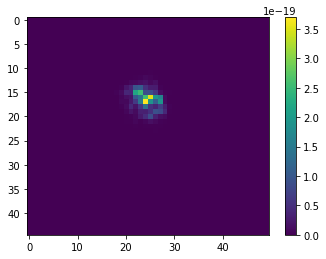

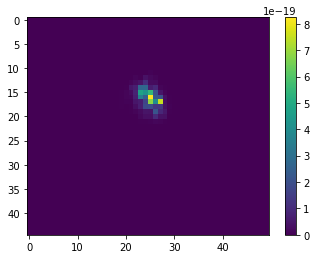

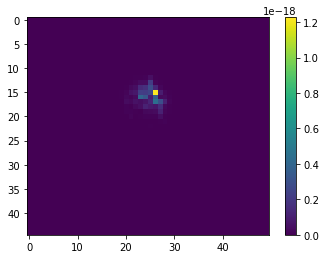

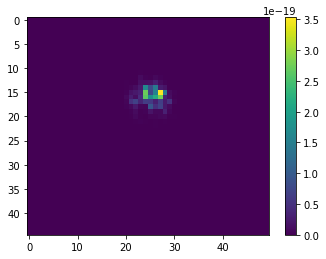

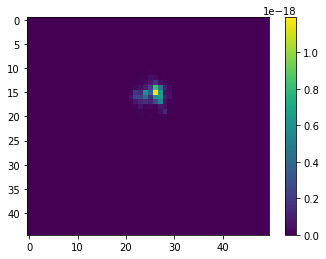

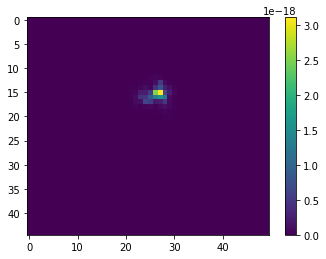

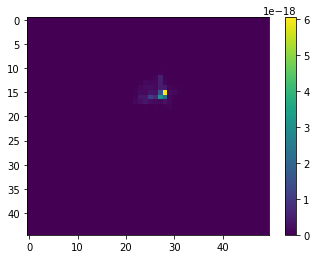

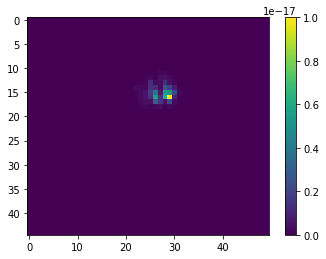

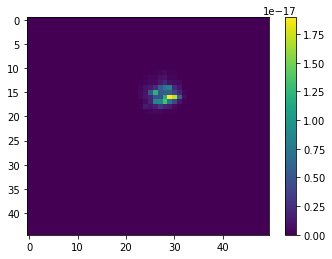

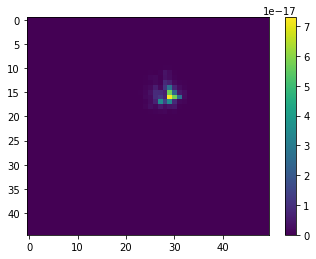

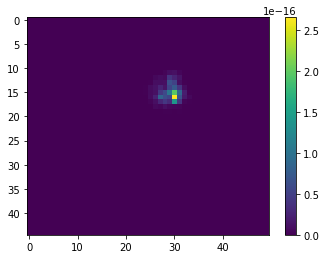

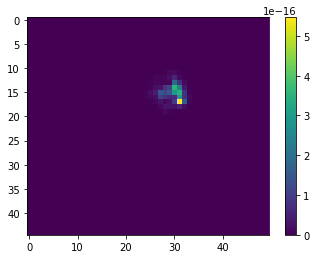

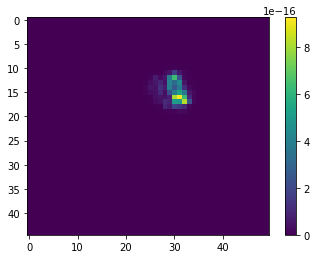

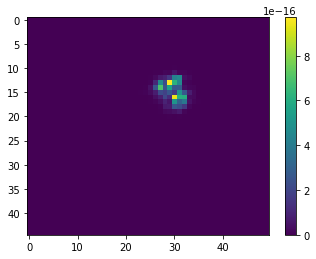

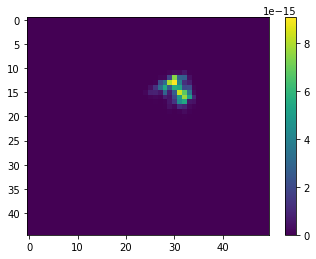

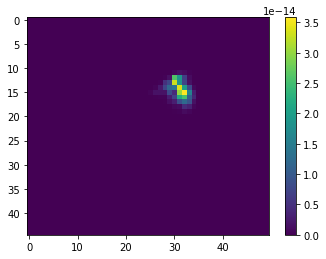

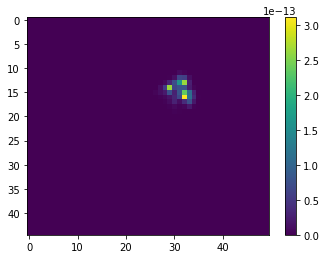

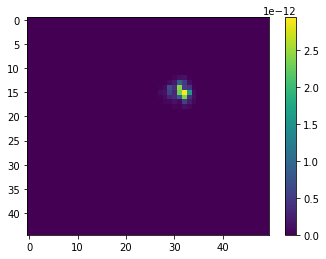

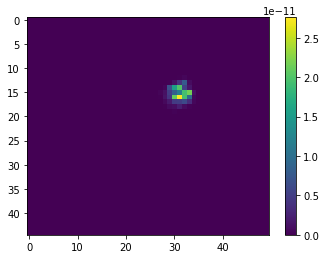

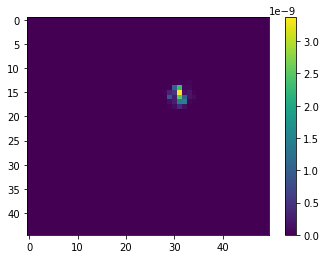

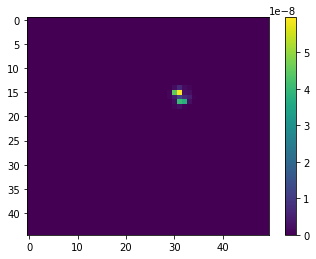

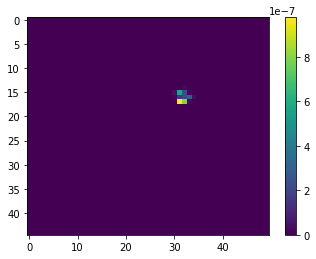

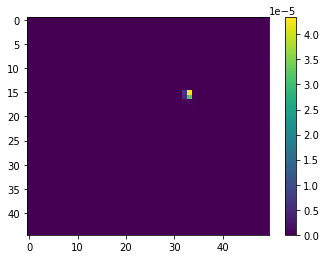

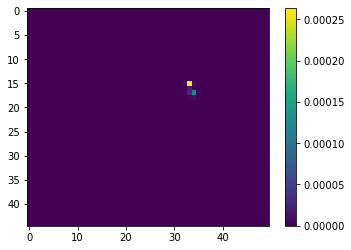

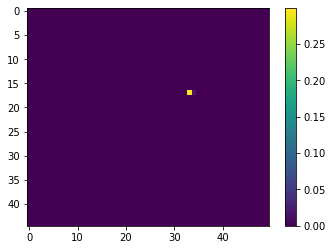

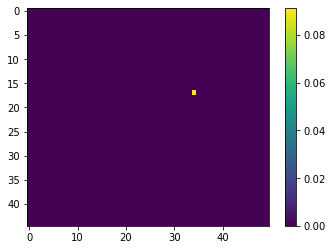

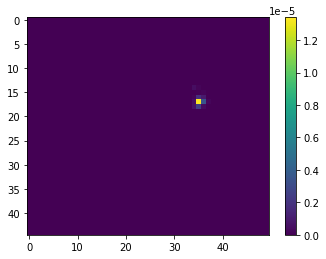

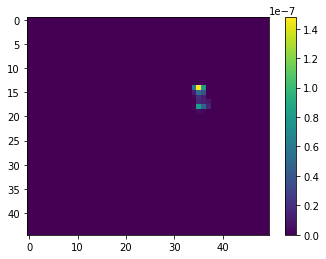

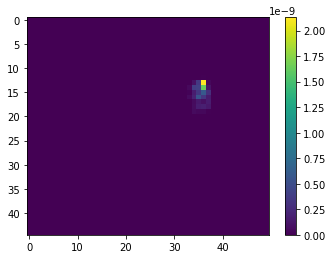

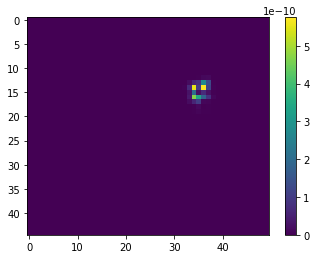

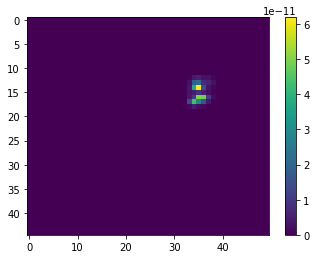

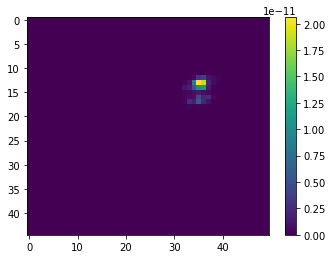

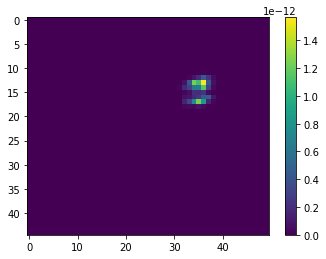

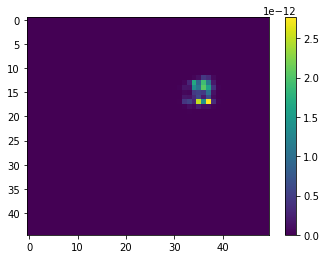

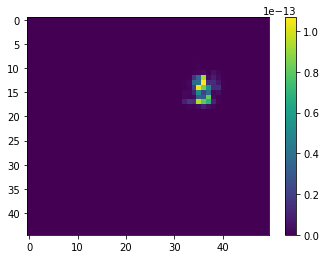

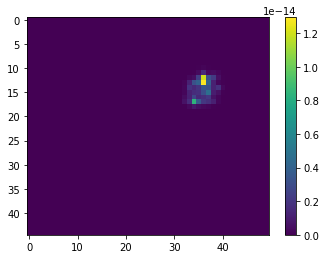

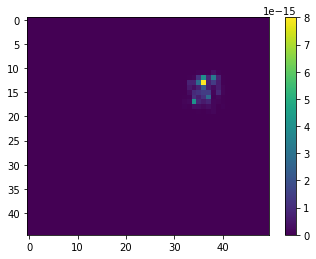

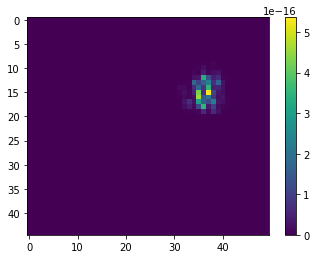

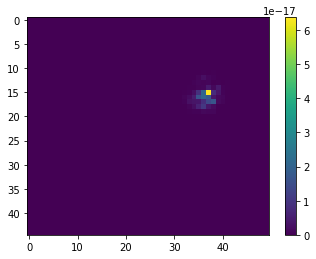

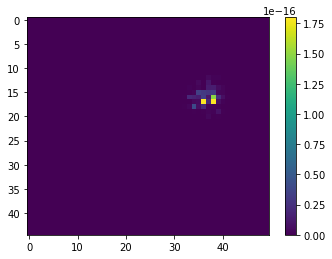

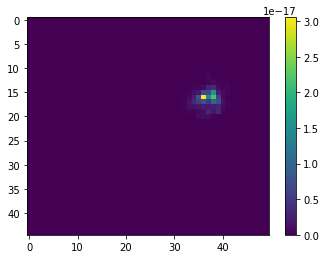

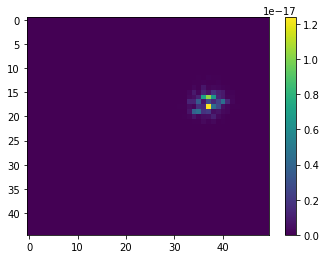

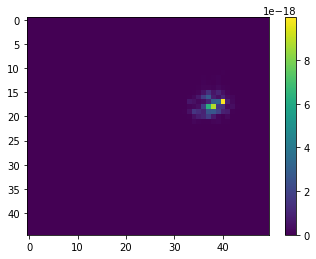

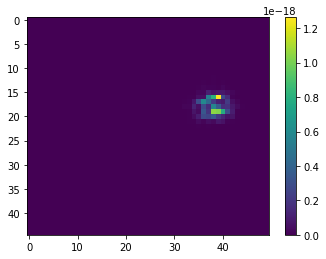

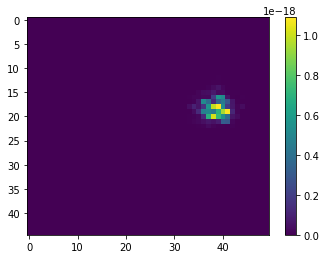

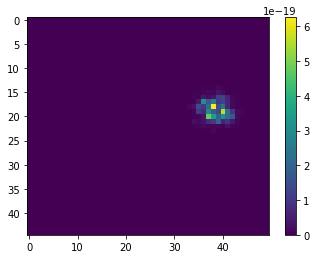

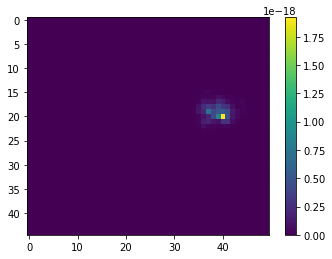

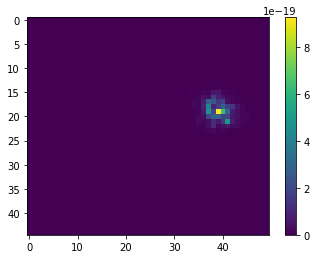

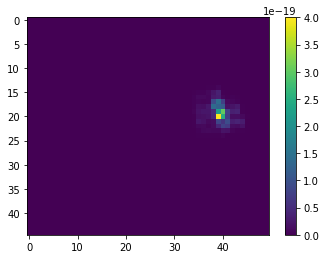

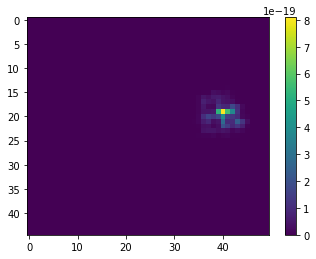

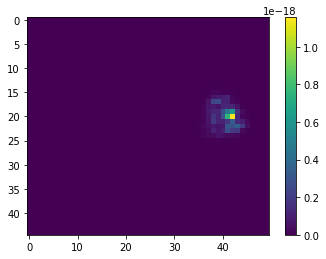

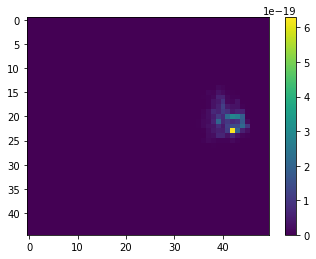

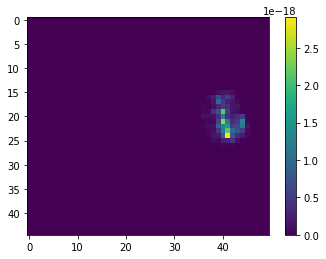

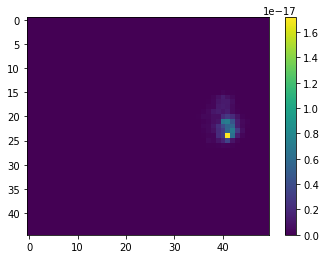

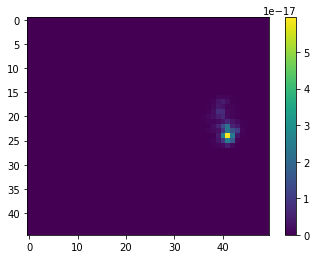

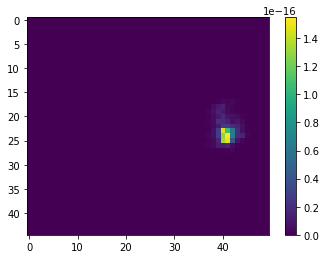

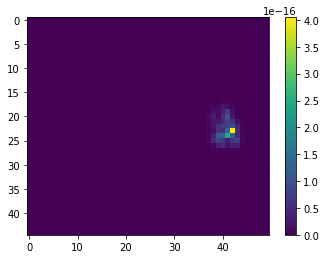

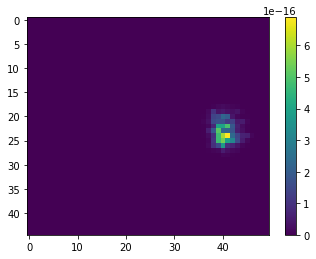

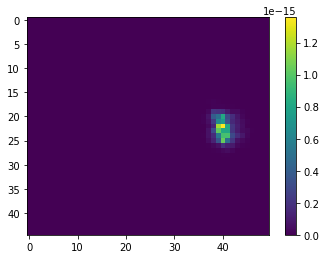

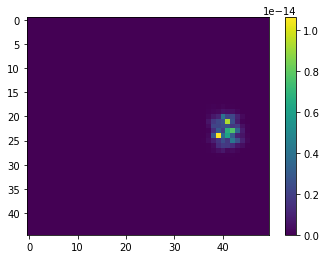

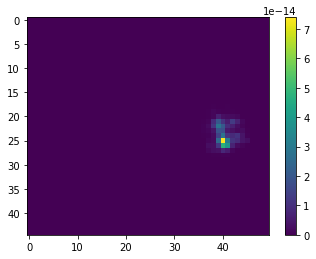

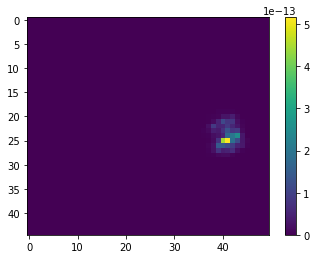

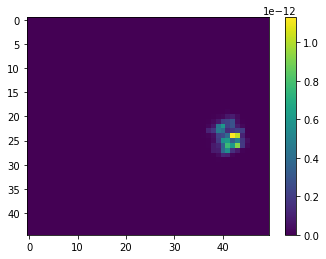

In [6]:

max_clip=8
sigma=np.sqrt(np.max(counts))*np.sqrt(2*max_clip)
probmap=np.exp((posemap-np.max(posemap))/sigma)
toshow=probmap

for i in range(posemap.shape[0]):
    
    if True:
        plt.figure()
        #plt.imshow(posemap[i,:,:])
        #plt.imshow(posemap[i,125:175,125:175])
        plt.imshow(toshow[i,225:270,225:275])
        
        plt.colorbar()
        plt.show()

In [8]:
best_point = np.unravel_index(np.argmax(posemap, axis=None), posemap.shape)
print("best point {}".format(best_point))
print("which is Theta={} x={} y={}".format(ts[best_point[0]],xs[best_point[1]],ys[best_point[2]]))
print("compare to {}".format(last_lidar_pose_log))

newpose=mymap.pose_map_to_pose_prediction2_with_theta_faster(posemap,xs,ys,ts,counts,center=latest_pose,spread_size_x=30,spread_size_y=30)
print("check pose {}".format(newpose.pretty_str()))


best point (0, 247, 247)
which is Theta=-2.718806243275158 x=-0.10020080321285008 y=-0.10020080321285008
compare to {'pose_measurement': {'vals': [-0.35099756607415694, 0.4591956917448999, -1.2470511677050706], 'covariance': [[0.0006424480603366905, -2.7474568512320108e-05, 2.7751471598502775e-07], [-2.7474568512320108e-05, 0.001021295413198071, 5.219761187857941e-05], [2.7751471598502775e-07, 5.219761187857941e-05, 0.0003463025780090471]]}, 'timestamp': 1618954602.8504562, 'notes': 'lidar'}
check pose  -0.08+/-0.09 -0.05+/-0.15 -2.6+/-0.4
